# **Analyse in Pandas en PowerBI**
Groep 8

***Airport iata codes*** <br>
**FR** = Ryanair <br>
**SN** = Brussels Airlines <br>
**HV** = Transavia <br>
**TB** = Tui

In [2]:
import os
import csv
import sys
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector as sql
from dotenv import load_dotenv
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')

dotenv_path = "../.env"
load_dotenv(dotenv_path)

True

## Data

### CSV (overbodig)

In [ ]:
folder = 'C:\\ProgramData\\MySQL\\MySQL Server 8.0\\Uploads\\'
files = os.listdir(folder)

In [ ]:
# create new dataframe
allData = pd.DataFrame()

# loop through files and append to dataframe
for i, file in enumerate(files):
    filepath = os.path.join(folder, file)
    df = pd.read_csv(filepath, skiprows=0)
    allData = allData.append(df, ignore_index=True)

# save to csv
allData.to_csv('../analyse/allData.csv', index=False)

### Datawarehouse MySQL Workbench

In [3]:
# make a connection to the database
dwh = sql.connect(
    host="127.0.0.1",   # ip-adres
    port=3306,   # poortnummer
    user=os.getenv("USER"),   # username
    password=os.getenv("PASSWORD"),   # wachtwoord
    database="AirFaresDWH"   # naam van de datawarehouse in mysql workbench
    # database="groep8dep"   # naam van de OLTP database in mysql workbench
)

# check if the connection succeeded
print(dwh)

In [4]:
# create cursor
cursor = dwh.cursor()

# use the right database
cursor.execute("USE AirFaresDWH")

# get the column names
cursor.execute("SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'dimairline'")
columns_airline = cursor.fetchall()

cursor.execute("SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'dimairport'")
columns_airport = cursor.fetchall()

cursor.execute("SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'dimdate'")
columns_date = cursor.fetchall()

cursor.execute("SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'dimflight'")
columns_flight = cursor.fetchall()

cursor.execute("SELECT COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'factflightfare'")
columns_fact = cursor.fetchall()


# get all the data
cursor.execute("SELECT * FROM dimairline")
rows_airline = cursor.fetchall()

cursor.execute("SELECT * FROM dimairport")
rows_airport = cursor.fetchall()

cursor.execute("SELECT * FROM dimdate")
rows_date = cursor.fetchall()

cursor.execute("SELECT * FROM dimflight")
rows_flight = cursor.fetchall()

cursor.execute("SELECT * FROM factflightfare")
rows_fact = cursor.fetchall()


# remove the first line with null values
rows_airline = rows_airline[1:]
rows_airport = rows_airport[1:]
rows_date = rows_date[1:]
rows_flight = rows_flight[1:]
rows_fact = rows_fact[1:]

# create dataframes
df_airline = pd.DataFrame(rows_airline, columns=[i[0] for i in columns_airline])
df_airport = pd.DataFrame(rows_airport, columns=[i[0] for i in columns_airport])
df_date = pd.DataFrame(rows_date, columns=[i[0] for i in columns_date])
df_flight = pd.DataFrame(rows_flight, columns=[i[0] for i in columns_flight])
df_fact = pd.DataFrame(rows_fact, columns=[i[0] for i in columns_fact])

# create a new dataframe with all the data
# df = pd.merge(df_fact, df_flight, on='flight_key')
# df = pd.merge(df, df_airline, on='airline_key')
# df = pd.merge(df, df_airport, left_on='depatureAirportKey', right_on='airport_key')
# df = pd.merge(df, df_airport, left_on='arrivalAirportKey', right_on='airport_key', how='inner')
# df = pd.merge(df, df_date, left_on='scrapeDateKey', right_on='date_key')
# df = pd.merge(df, df_date, left_on='departureDateKey', right_on='date_key')
# df = pd.merge(df, df_date, left_on='arrivalDateKey', right_on='date_key')

# create the query to connect the tables
query = """
SELECT * FROM factflightfare
INNER JOIN dimflight ON factflightfare.flight_key = dimflight.flight_key
INNER JOIN dimairline ON factflightfare.airline_key = dimairline.airline_key
INNER JOIN dimairport AS dep_airport ON factflightfare.depatureAirportKey = dep_airport.airport_key
INNER JOIN dimairport AS arr_airport ON factflightfare.arrivalAirportKey = arr_airport.airport_key
INNER JOIN dimdate AS scrape_date ON factflightfare.scrapeDateKey = scrape_date.date_key
INNER JOIN dimdate AS dep_date ON factflightfare.departureDateKey = dep_date.date_key
INNER JOIN dimdate AS arr_date ON factflightfare.arrivalDateKey = arr_date.date_key
"""

# create the dataframe
df = pd.read_sql(query, dwh)

# show the columns of the df
print(df.columns)

# show the df
df

Index(['flightfare_key', 'flight_key', 'airline_key', 'depatureAirportKey',
       'arrivalAirportKey', 'scrapeDateKey', 'departureDateKey',
       'arrivalDateKey', 'availableSeats', 'price', 'flight_key', 'flight_id',
       'flightnumber', 'numberOfStops', 'departureTime', 'arrivalTime',
       'duration', 'start_date', 'end_date', 'airline_key',
       'airline_iata_code', 'airline_name', 'country', 'airport_key',
       'airport_iata_code', 'airport_name', 'location', 'country',
       'airport_key', 'airport_iata_code', 'airport_name', 'location',
       'country', 'date_key', 'date', 'day_of_week', 'day_of_month',
       'day_of_year', 'year', 'dayName', 'monthName', 'nameOfQuarter',
       'numberOfQuarter', 'isWeekend', 'isWeekDay', 'isHoliday', 'date_key',
       'date', 'day_of_week', 'day_of_month', 'day_of_year', 'year', 'dayName',
       'monthName', 'nameOfQuarter', 'numberOfQuarter', 'isWeekend',
       'isWeekDay', 'isHoliday', 'date_key', 'date', 'day_of_week',
      

,flightfare_key,flight_key,airline_key,depatureAirportKey,arrivalAirportKey,scrapeDateKey,departureDateKey,arrivalDateKey,availableSeats,price,...,day_of_month,day_of_year,year,dayName,monthName,nameOfQuarter,numberOfQuarter,isWeekend,isWeekDay,isHoliday
0,1,641,1,7,4,20230420,20230522,20230522,-1,21.99,...,22,142,2023,Monday,May,Q2,2,0,1,0
1,2,13,1,5,1,20230420,20230521,20230521,3,90.73,...,21,141,2023,Sunday,May,Q2,2,1,0,0
2,3,171,1,7,1,20230420,20230521,20230521,2,83.79,...,21,141,2023,Sunday,May,Q2,2,1,0,0
3,4,1114,1,7,10,20230420,20230521,20230521,-1,93.36,...,21,141,2023,Sunday,May,Q2,2,1,0,0
4,5,375,1,7,2,20230420,20230521,20230521,4,132.94,...,21,141,2023,Sunday,May,Q2,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252716,259268,13690,4,13,17,20230426,20230712,20230712,-1,309.99,...,12,193,2023,Wednesday,July,Q3,3,0,1,1
252717,259269,13690,4,13,17,20230430,20230712,20230712,-1,319.99,...,12,193,2023,Wednesday,July,Q3,3,0,1,1
252718,259270,13690,4,13,17,20230423,20230712,20230712,-1,309.99,...,12,193,2023,Wednesday,July,Q3,3,0,1,1
252719,259271,13690,4,13,17,20230418,20230712,20230712,-1,309.99,...,12,193,2023,Wednesday,July,Q3,3,0,1,1


## Questions

### 1) Welke vliegtuigmaatschappij is gemiddeld de goedkoopste / de duurste?

Kan zowel in Python als in PowerBI

De goedkoopste vliegtuigmaatschappij is FR met een gemiddelde prijs van 114.36 euro.
De duurste vliegtuigmaatschappij is TB met een gemiddelde prijs van 201.22 euro.


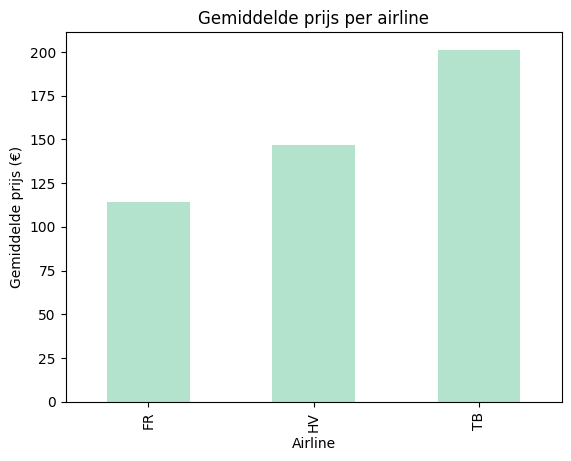

In [5]:
# read the data
data = df

# group the data by airline and calculate the average price
grouped_data = data.groupby(['airline_iata_code'])['price'].mean()
sorted_data = grouped_data.sort_values()

# print the results
print("De goedkoopste vliegtuigmaatschappij is " + sorted_data.index[0] + " met een gemiddelde prijs van", round(sorted_data[0], 2), "euro.")
print("De duurste vliegtuigmaatschappij is " + sorted_data.index[-1] + " met een gemiddelde prijs van", round(sorted_data[-1], 2), "euro.")

# plot the results
grouped_data.plot(kind='bar', colormap='Pastel2')
plt.title('Gemiddelde prijs per airline')
plt.xlabel('Airline')
plt.ylabel('Gemiddelde prijs (€)')
plt.show()

### 2) Hoe vaak vliegt elke vliegtuigmaatschappij per week naar elk van de bestemmingen?

Kan zowel in Python als in PowerBI

In [6]:
# read the data
data = df

# add new column for weekday
data['weekday'] = pd.to_datetime(data['departureDateKey']).dt.day_name()

# group the data by airline and destination + count the number of flights per week
grouped_data = data.groupby(['airline_iata_code', 'arrivalAirportKey', 'weekday']).size().reset_index(name='countOfFlights')

pivoted_data = pd.pivot_table(grouped_data, values='countOfFlights', index=['airline_iata_code'], columns=['arrivalAirportKey', 'weekday'], fill_value=0)

sorted_data = pivoted_data.sort_values(by=['airline_iata_code'])

pd.DataFrame(sorted_data)

for i in range(len(sorted_data)):
    print("De vliegtuigmaatschappij " + sorted_data.index[i] + " heeft", sorted_data.iloc[i].sum(), "in totaal.")

De vliegtuigmaatschappij FR heeft 92896 in totaal.
De vliegtuigmaatschappij HV heeft 25469 in totaal.
De vliegtuigmaatschappij TB heeft 134356 in totaal.


In [15]:
# read the data
data = df

# iterate over the data and add to array
dataArr = []
for i in range(len(data)):
    dataArr.append(data.iloc[i])

# create dictionary to hold count of flights per airline and destination
flights_count = {}

# iterate over flights and update count in dictionary
for flight in dataArr:
    airline = flight['airline_iata_code']
    destination = flight['arrivalAirportKey']
    if airline not in flights_count:
        flights_count[airline] = {}
    if destination not in flights_count[airline]:
        flights_count[airline][destination] = 0
    flights_count[airline][destination] += 1

# create list of airlines and destinations
airlines = list(flights_count.keys())
destinations = list(set(dest for dests in flights_count.values() for dest in dests.keys()))

# print table header
print('Airline'.ljust(15), end='')
for dest in destinations:
    # switch the dest to the correct airport name
    match dest:
        case 1:
            dest = 'Malaga'
        case 2:
            dest = 'Alicante'
        case 4:
            dest = 'Brindisi'
        case 6:
            dest = 'Corfu'
        case 8:
            dest = 'Faro'
        case 9:
            dest = 'Kreta'
        case 10:
            dest = 'Ibiza'
        case 12:
            dest = 'Napels'
        case 14:
            dest = 'Palma'
        case 15:
            dest = 'Palermo'
        case 16:
            dest = 'Rhodos'
        case 17:
            dest = 'Tenerife'
    print(str(dest).rjust(10), end='')
print('')

# print table body
for airline in airlines:
    print(airline.ljust(15), end='')
    for dest in destinations:
        count = flights_count.get(airline, {}).get(dest, 0)
        print(str(count).rjust(10), end='')
    print('')

Airline            Malaga  Alicante  Brindisi     Corfu      Faro     Kreta     Ibiza    Napels     Palma   Palermo    Rhodos  Tenerife
FR                  15524     15011      5418      3811     12041      2335      4543     10384     10011      5743      3467      4608
TB                  25572     25756      2132      4559      2637     12912      9734      2232     16087      2232     10657     19846
HV                   3995      6698         0         0      5947      2768      4691         0         0         0         0      1370


In [17]:
# read the data
data = df

# open new csv file
with open('../analyse/vluchtenPerWeek.csv', 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['airline_iata_code', 'arrival_airport_iata_code', 'weekNr', 'countOfFlights'])

# iterate over the data and add to array
dataArr = []
for i in range(len(data)):
    dataArr.append(data.iloc[i])

# initialize dictionary to store flights per airline per destination per week
flights_per_week = {}

# loop through the rows
for row in dataArr:
    airline = row['airline_iata_code']
    destination = row['arrivalAirportKey']
    departure_date = row['departureDateKey']

    # convert departure date to datetime object
    departure_date_obj = datetime.datetime.strptime(str(departure_date), '%Y%m%d')

    # extract week number
    week_number = departure_date_obj.strftime('%W')

    # add to flights_per_week dictionary
    if airline not in flights_per_week:
        flights_per_week[airline] = {}
    if destination not in flights_per_week[airline]:
        flights_per_week[airline][destination] = {}
    if week_number not in flights_per_week[airline][destination]:
        flights_per_week[airline][destination][week_number] = 0
    flights_per_week[airline][destination][week_number] += 1

with open('../analyse/vluchtenPerWeek.csv', 'a', newline='') as csv_file:
    # create csv writer
    writer = csv.writer(csv_file)

    # print flights per airline per destination per week
    for airline, destinations in flights_per_week.items():
        for destination, weeks in destinations.items():
            for week, num_flights in weeks.items():
                # print(f"Airline: {airline}, Destination: {destination}, Week: {week}, Flights: {num_flights}")
                writer.writerow([airline, destination, week, num_flights])

### 3) Welke vliegtuigmaatschappij biedt de snelste vlucht aan naar een bepaalde bestemming?   KYANA

Volgens mij in PowerBI

### 4) Welke vliegtuigmaatschappij biedt de goedkoopste vlucht aan naar een bepaalde bestemming?

Volgens mij in PowerBI

### 5) Welke vliegtuigmaatschappij biedt een vlucht aan zonder tussenstops, met maximum 1 tussentop, ... ?

Volgens mij in PowerBI

### 6) Rapport over prijsevolutie en beschibaarheidsevolutie doorheen de tijd?

Geen idee wat ze hiermee bedoelen

### 7) Is er een correlatie met de vakantiebestemmingen: zijn bepaalde bestemmingen significant duurder dan andere bestemmingen?

Kan in zowel python als PowerBI denk ik?

### 8) Zijn de prijzen gerelateerd aan vakantieperiodes hier of ter plaatse?

Volgens mij in PowerBI

### 9) Kan je de prijsstrategie afleiden? (Invloed van aantal dagen voor vertrek, invloed van beschikbaarheid)

Weet ik niet in Python of PowerBI

### 10) Is er een link tussen prijs en afstand (en duration)? Bijvoorbeeld Tenerife is anderhalf uur verder dan Alicante.

Geen idee wat er hier moet gebeuren dus ook geen idee van Python of PowerBI

### 11) Is er een link tussen prijs en land? Zijn sommige landen opvallend duurder (en kan dit niet verklaard worden door de extra afstand)

Geen idee wat er hier moet gebeuren dus ook geen idee van Python of PowerBI

### 12) Hoeveel dagen voor vertrek is een vlucht volgeboekt? Zijn er bestemmingen waarbij de vluchten bijna volgeboekt zijn?

Kan in zowel Pyhton als PowerBI volgens mij

### 13) Hoeveel procent van de vluchten zijn volgeboekt? / Hoeveel plaatsen zijn er nog vrij 5 dagen voor vertrek.   KYANA

In Python volgens mij

### 14) Plot het verband tussen de prijs en het aantal dagen voor vertrek voor Ryanair voor de afgelopen maand. Maak gebruik van regressie om de prijzen te voorspellen voor de volgende maand.

Plotten kan in zowel PowerBI als in Python, regressie is sowieso in Python

#### Plot het verband tussen de prijs en het aantal dagen voor vertrek voor Ryanair voor de afgelopen maand.

Text(0, 0.5, 'Prijs (€)')

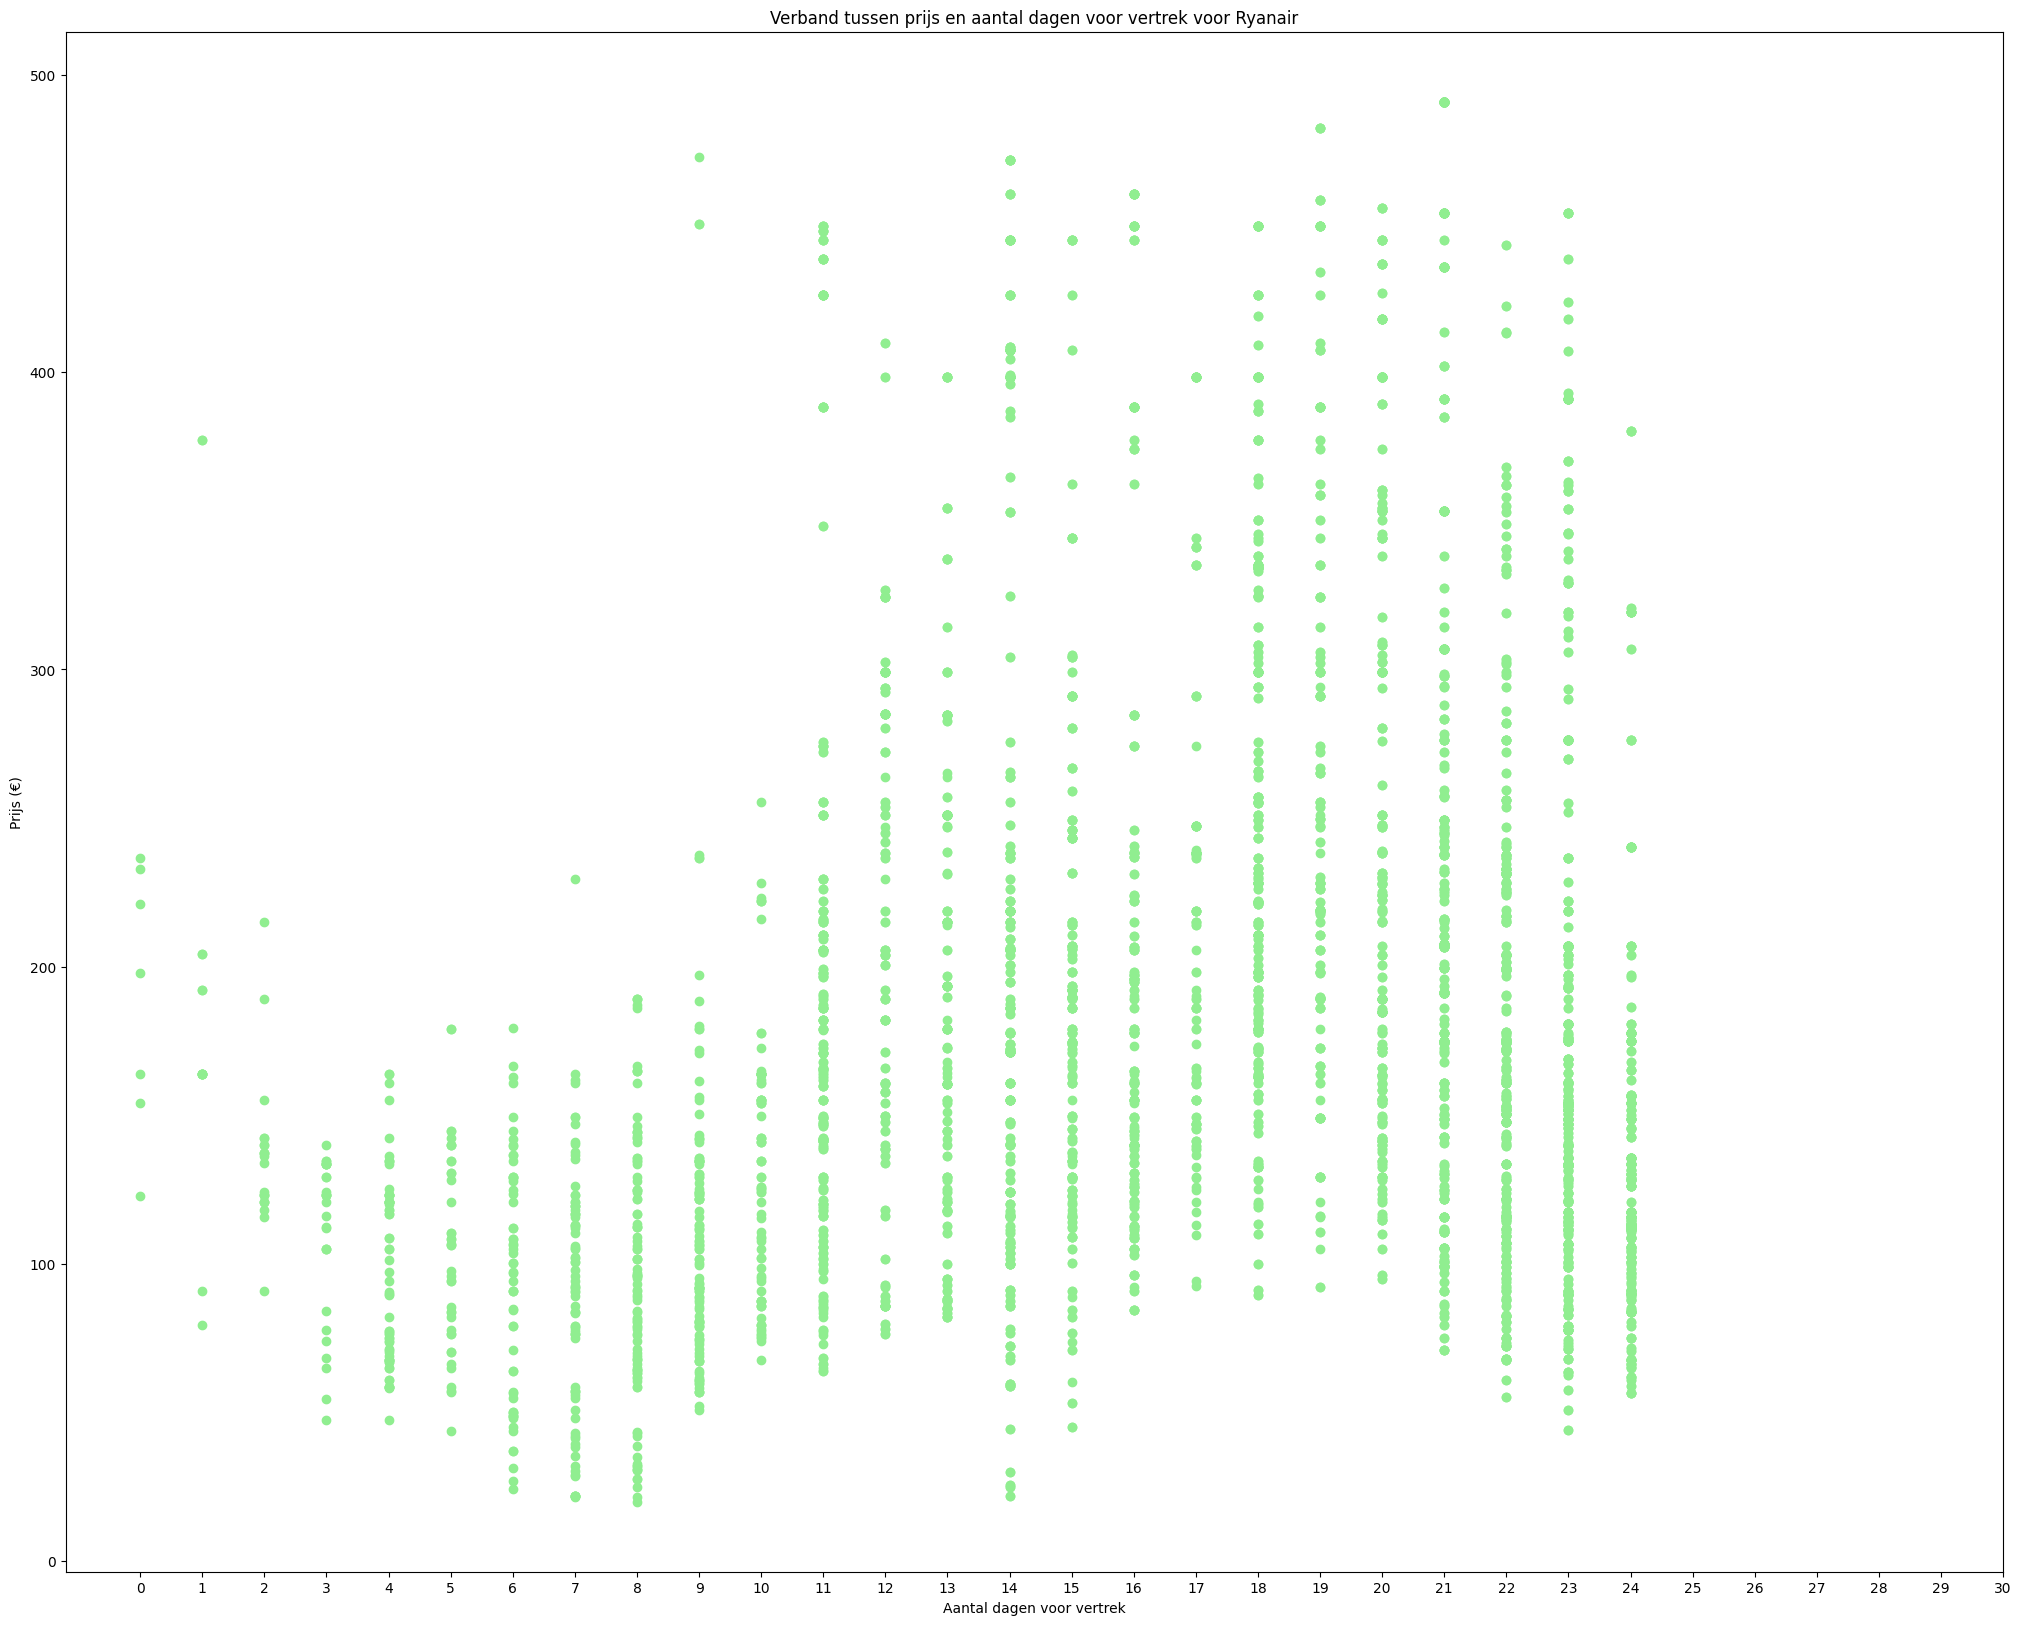

In [19]:
# read the data
data = df

# filter the data for Ryanair
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# add new column for days before departure
data['days_before_departure'] = (data['departure_date'] - data['departure_date'].min()).dt.days

# previous month with datetime
previous_month = datetime.datetime.now() - datetime.timedelta(days=30)

# today with datetime
today = datetime.datetime.now()

# filter the data for the last month ()
data = data[(data['departure_date'] >= previous_month) & (data['departure_date'] <= today)]

# plot the results
plt.figure(figsize=(25, 20))
plt.plot(data['days_before_departure'], data['price'], 'o', color='lightgreen')
plt.title('Verband tussen prijs en aantal dagen voor vertrek voor Ryanair')
plt.xticks(range(0, 31, 1))
plt.xlabel('Aantal dagen voor vertrek')
plt.ylabel('Prijs (€)')

#### Maak gebruik van regressie om de prijzen te voorspellen voor de volgende maand.

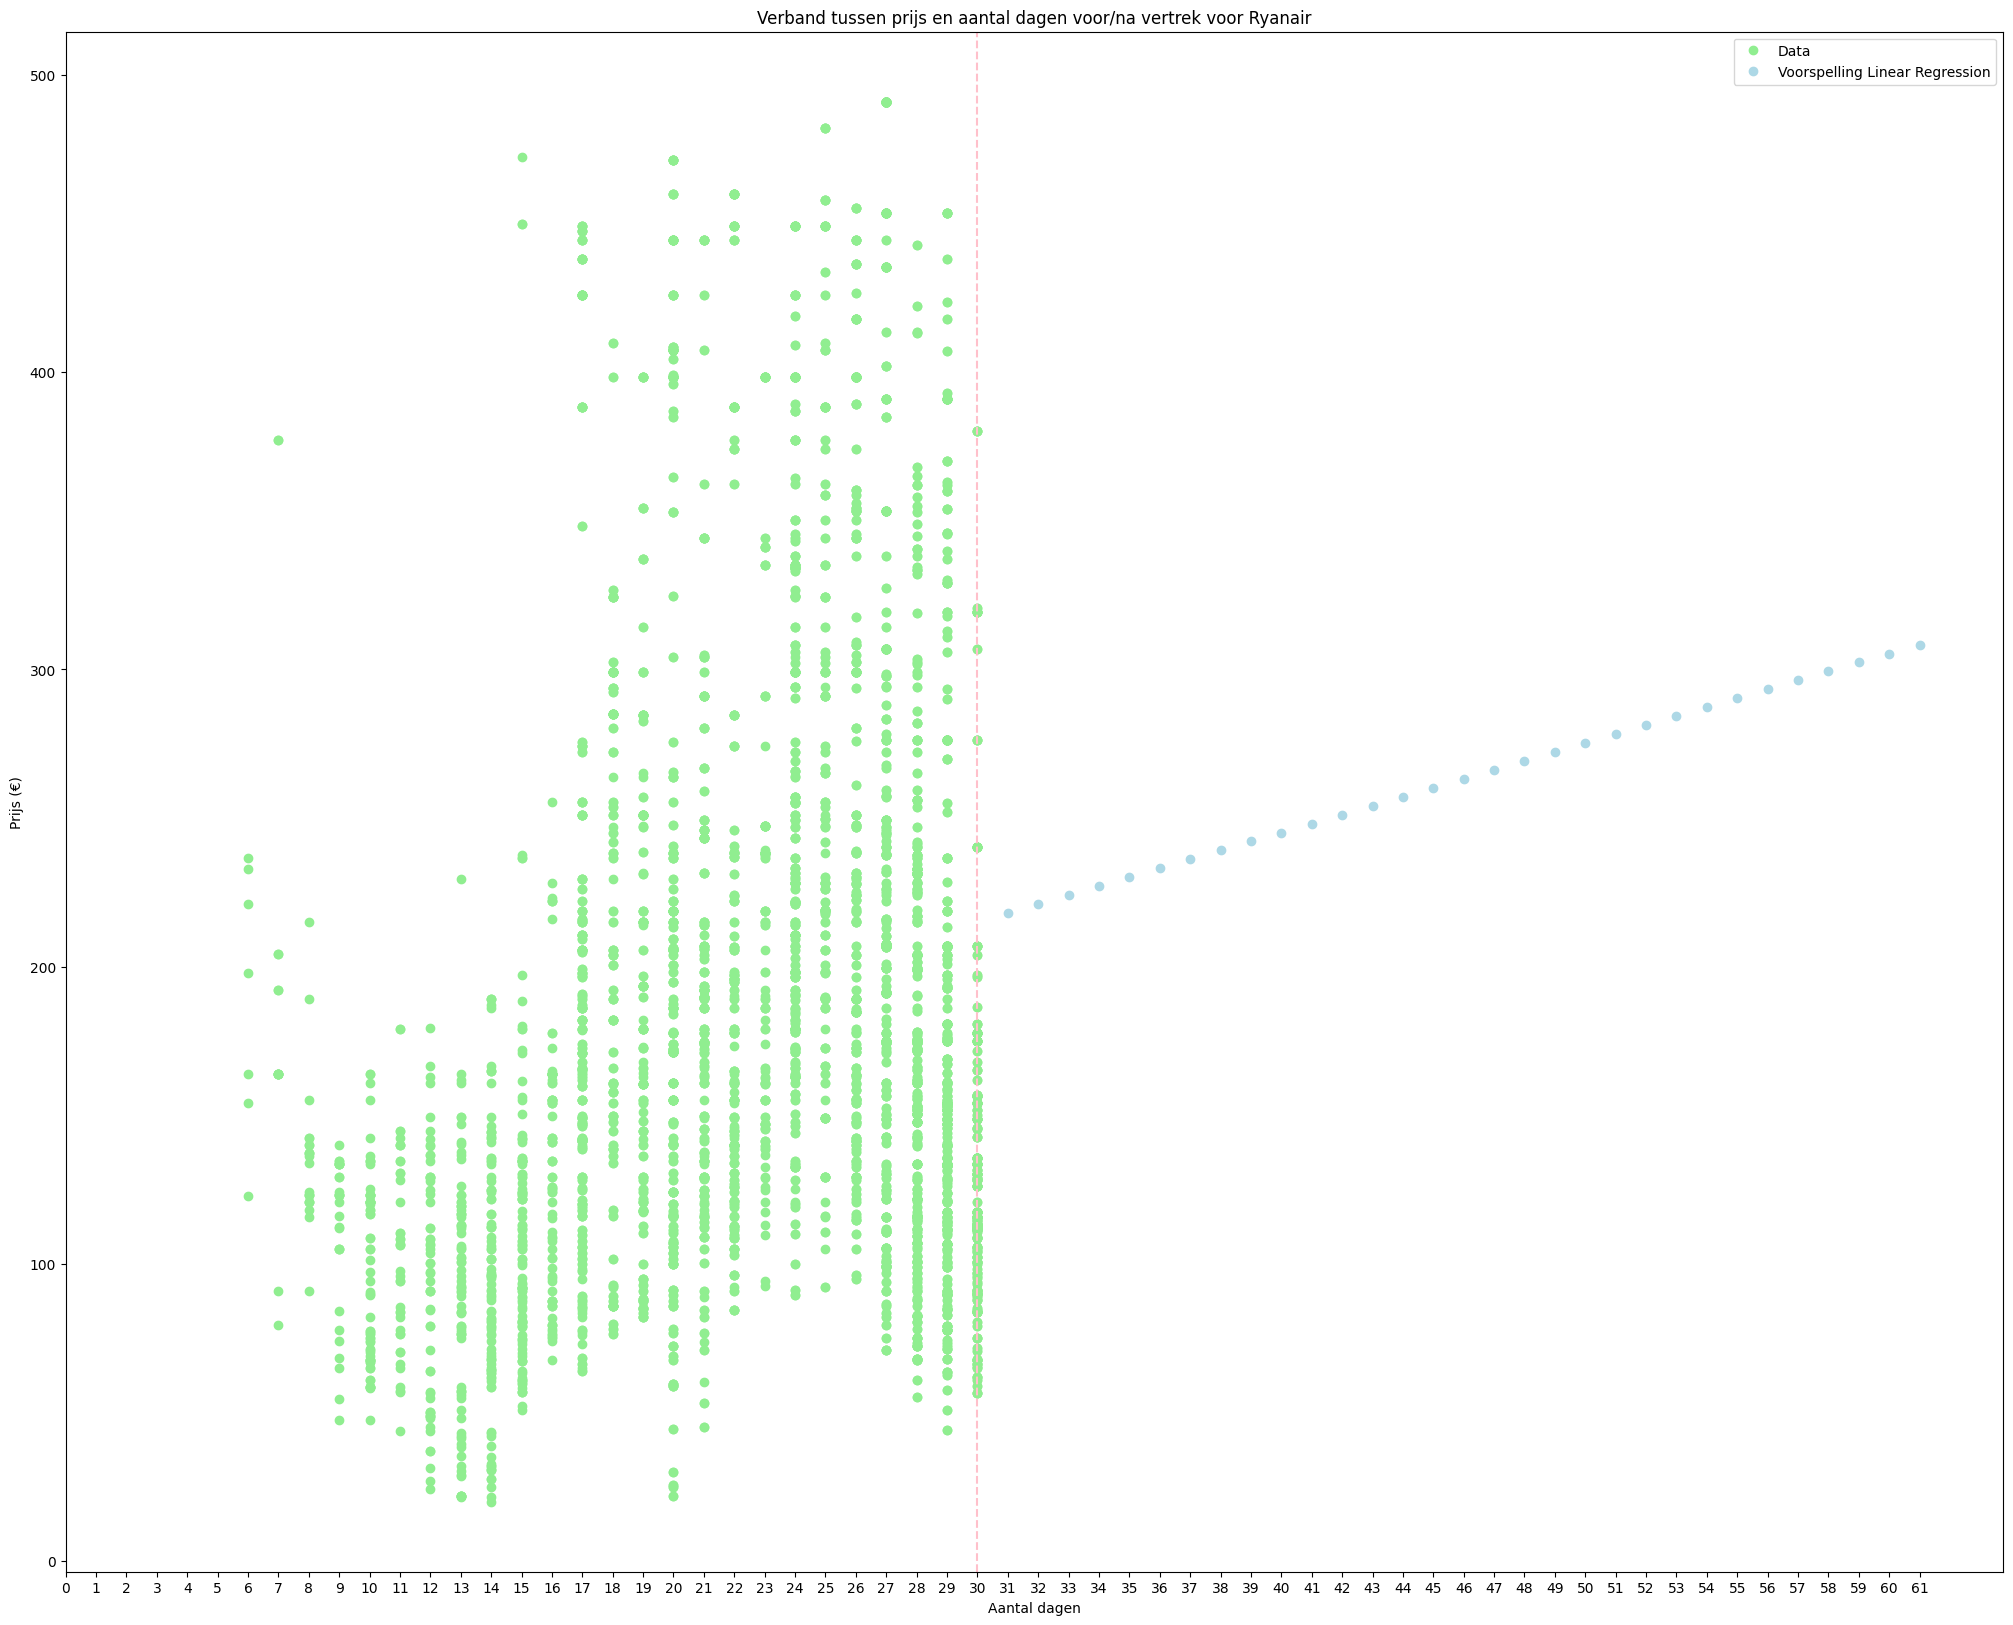

Accuracy score: 0.026790939903053368


In [21]:
# read data for Ryanair only
data = df
data = data[data['airline_iata_code'] == 'FR']

# convert departure date to datetime object
data['departure_date'] = pd.to_datetime(data['departureDateKey'], format='%Y%m%d')

# get date range for last month
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
last_month = today - pd.DateOffset(months=1)
date_range = pd.date_range(start=last_month, end=today, freq='D')

# filter data for last month
data = data[data['departure_date'].isin(date_range)]

# create linear regression model
lr = LinearRegression()

# fit the model
X_train = (data['departure_date'] - last_month).dt.days.values.reshape(-1, 1)
y_train = data['price'].values.reshape(-1, 1)
lr.fit(X_train, y_train)

# predict prices for next month
next_month = today + pd.DateOffset(months=1)
next_month_range = pd.date_range(start=tomorrow, end=next_month, freq='D')
X_test = (next_month_range - last_month).days.values.reshape(-1, 1)
y_pred_lr = lr.predict(X_test)

# plot results
plt.figure(figsize=(25, 20))
plt.plot(X_train, y_train, 'o', color='lightgreen')
plt.plot(X_test, y_pred_lr, 'o', color='lightblue')
plt.axvline(x=30, color='pink', linestyle='--')
plt.title('Verband tussen prijs en aantal dagen voor/na vertrek voor Ryanair')
plt.xticks(range(0, 62, 1))
plt.xlabel('Aantal dagen')
plt.ylabel('Prijs (€)')
plt.legend(['Data', 'Voorspelling Linear Regression'])
plt.show()

# print the accuracy score
print(f"Accuracy score: {lr.score(X_train, y_train)}")

De x-as van deze grafiek moet je interpreteren als volgt: 
- Van 0 tot en met 30 zijn de waarden voor de dagen voor vertrek (30 = 0 dagen voor vertrek, dus de dag zelf ; 0 = 30 dagen voor vertrek)
- Van 31 tot en met 61 zijn de dagen van de komende maand (31 = morgen, 61 = volgende maand)

Samenvattend moet je kijken naar de verticale lijn, dit is het 'midden': alles ervoor zijn het aantal dagen voor vertrek, alles erna zijn de komende dagen (hoe dichter bij de lijn, hoe korter bij het heden; hie verder weg, hoe verder in het verleden of de toekomst)

### 15) In PowerBI een kaart maken met de mogelijke bestemmingen als de prijs in een bepaalde range moet liggen (op een bepaald moment).

In PowerBI

Is volledig opgelost, blad noemt "15"